In [1]:
import torch
import pandas as pd
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [2]:
df_finalEy = pd.read_pickle('EncodingData.pkl')

In [3]:
# import re
# df_finalEy = df_finalEy.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [4]:
# df_finalEy = df_finalEy.iloc[:500000]
df_finalEy

,startingAirport,destinationAirport,isBasicEconomy,isRefundable,baseFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeRaw,segmentsArrivalTimeRaw,segmentsAirlineName,...,segmentsCabinCode,segmentsDurationInMinutes,days_to_flight,fareDifference,fareRatio,fareMarkup,DepartureDate,DepartureDate:month,DepartureDate:day,DepartureDate:day_of_week
0,ATL,BOS,False,False,217.67,9.0,947.0,2022-04-17T12:57:00.000-04:00,2022-04-17T15:26:00.000-04:00,Delta,...,coach,149.0,1,30.93,1.142096,14.209583,2022-04-17,4,17,6
1,ATL,BOS,False,False,217.67,4.0,947.0,2022-04-17T06:30:00.000-04:00,2022-04-17T09:00:00.000-04:00,Delta,...,coach,150.0,1,30.93,1.142096,14.209583,2022-04-17,4,17,6
2,ATL,BOS,False,False,217.67,9.0,947.0,2022-04-17T11:35:00.000-04:00,2022-04-17T14:05:00.000-04:00,Delta,...,coach,150.0,1,30.93,1.142096,14.209583,2022-04-17,4,17,6
3,ATL,BOS,False,False,217.67,8.0,947.0,2022-04-17T13:59:00.000-04:00,2022-04-17T16:31:00.000-04:00,Delta,...,coach,152.0,1,30.93,1.142096,14.209583,2022-04-17,4,17,6
4,ATL,BOS,False,False,217.67,9.0,947.0,2022-04-17T09:59:00.000-04:00,2022-04-17T12:33:00.000-04:00,Delta,...,coach,154.0,1,30.93,1.142096,14.209583,2022-04-17,4,17,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165943,ORD,LAX,False,False,128.37,7.0,1745.0,2022-11-12T08:19:00.000-06:00,2022-11-12T10:49:00.000-08:00,American Airlines,...,coach,270.0,38,24.23,1.188751,18.875127,2022-11-12,11,12,5
165944,ORD,LAX,False,False,128.37,7.0,1745.0,2022-11-12T19:45:00.000-06:00,2022-11-12T22:19:00.000-08:00,American Airlines,...,coach,274.0,38,24.23,1.188751,18.875127,2022-11-13,11,13,6
165945,ORD,LAX,False,False,128.37,7.0,1745.0,2022-11-12T14:00:00.000-06:00,2022-11-12T16:39:00.000-08:00,American Airlines,...,coach,279.0,38,24.23,1.188751,18.875127,2022-11-12,11,12,5
165946,ORD,LAX,False,False,128.37,7.0,1745.0,2022-11-12T09:52:00.000-06:00,2022-11-12T12:31:00.000-08:00,American Airlines,...,coach,279.0,38,24.23,1.188751,18.875127,2022-11-12,11,12,5


In [6]:
#Preparing categorical attributes for Frequency Encoding 
categorical_attributes = list(df_finalEy.select_dtypes(include=['string']).columns)
categorical_attributes.remove('segmentsDepartureTimeRaw')
categorical_attributes.remove('segmentsArrivalTimeRaw')
numerical_attributes = list(df_finalEy.select_dtypes(include=['float64', 'int64', 'bool', 'int32']).columns)

In [7]:
df_categorical = df_finalEy[categorical_attributes]
df_numerical = df_finalEy[numerical_attributes]

## Frequency Encoding

In [8]:
#  Frequency Encoding  each categorical column
for col in df_categorical:
    # Calculating frequency of each category 
    freq_encoding = df_finalEy[col].value_counts(normalize=False)
    
    # Mapping frequencies to the original data
    df_finalEy[col + '_freq_encoded'] = df_finalEy[col].map(freq_encoding)

df_finalEy.head()


,startingAirport,destinationAirport,isBasicEconomy,isRefundable,baseFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeRaw,segmentsArrivalTimeRaw,segmentsAirlineName,...,fareMarkup,DepartureDate,DepartureDate:month,DepartureDate:day,DepartureDate:day_of_week,startingAirport_freq_encoded,destinationAirport_freq_encoded,segmentsAirlineName_freq_encoded,segmentsEquipmentDescription_freq_encoded,segmentsCabinCode_freq_encoded
0,ATL,BOS,False,False,217.67,9.0,947.0,2022-04-17T12:57:00.000-04:00,2022-04-17T15:26:00.000-04:00,Delta,...,14.209583,2022-04-17,4,17,6,1647697,2033496,4828113,3596470,21158070
1,ATL,BOS,False,False,217.67,4.0,947.0,2022-04-17T06:30:00.000-04:00,2022-04-17T09:00:00.000-04:00,Delta,...,14.209583,2022-04-17,4,17,6,1647697,2033496,4828113,3596470,21158070
2,ATL,BOS,False,False,217.67,9.0,947.0,2022-04-17T11:35:00.000-04:00,2022-04-17T14:05:00.000-04:00,Delta,...,14.209583,2022-04-17,4,17,6,1647697,2033496,4828113,374680,21158070
3,ATL,BOS,False,False,217.67,8.0,947.0,2022-04-17T13:59:00.000-04:00,2022-04-17T16:31:00.000-04:00,Delta,...,14.209583,2022-04-17,4,17,6,1647697,2033496,4828113,3596470,21158070
4,ATL,BOS,False,False,217.67,9.0,947.0,2022-04-17T09:59:00.000-04:00,2022-04-17T12:33:00.000-04:00,Delta,...,14.209583,2022-04-17,4,17,6,1647697,2033496,4828113,3596470,21158070


In [ ]:
df_finalEy

## Transformation

In [9]:
#Preparing numerical and boolean for conversion
numerical_attributes = ['baseFare', 'seatsRemaining', 'totalTravelDistance', 'segmentsDurationInMinutes', 
                        'days_to_flight', 'fareDifference', 'fareRatio', 'fareMarkup', 'departureHour', 'departureMinute',
       'arrivalHour', 'arrivalMinute']


boolean_attributes = ['isBasicEconomy', 'isRefundable']

In [10]:
#converting true or false to 0's and 1's
df_finalEy[boolean_attributes] = df_finalEy[boolean_attributes].astype(int)

In [11]:
#dropping previously encoded categorical columns
columns_to_drop = [
    'startingAirport',
    'destinationAirport',
    'segmentsAirlineName',
    'segmentsEquipmentDescription',
    'segmentsCabinCode',
    'DepartureDate'
]

df_finalEy_dropped = df_finalEy.drop(columns=columns_to_drop)
df_finalEy_dropped.head()

,isBasicEconomy,isRefundable,baseFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeRaw,segmentsArrivalTimeRaw,segmentsDurationInMinutes,days_to_flight,fareDifference,fareRatio,fareMarkup,DepartureDate:month,DepartureDate:day,DepartureDate:day_of_week,startingAirport_freq_encoded,destinationAirport_freq_encoded,segmentsAirlineName_freq_encoded,segmentsEquipmentDescription_freq_encoded,segmentsCabinCode_freq_encoded
0,0,0,217.67,9.0,947.0,2022-04-17T12:57:00.000-04:00,2022-04-17T15:26:00.000-04:00,149.0,1,30.93,1.142096,14.209583,4,17,6,1647697,2033496,4828113,3596470,21158070
1,0,0,217.67,4.0,947.0,2022-04-17T06:30:00.000-04:00,2022-04-17T09:00:00.000-04:00,150.0,1,30.93,1.142096,14.209583,4,17,6,1647697,2033496,4828113,3596470,21158070
2,0,0,217.67,9.0,947.0,2022-04-17T11:35:00.000-04:00,2022-04-17T14:05:00.000-04:00,150.0,1,30.93,1.142096,14.209583,4,17,6,1647697,2033496,4828113,374680,21158070
3,0,0,217.67,8.0,947.0,2022-04-17T13:59:00.000-04:00,2022-04-17T16:31:00.000-04:00,152.0,1,30.93,1.142096,14.209583,4,17,6,1647697,2033496,4828113,3596470,21158070
4,0,0,217.67,9.0,947.0,2022-04-17T09:59:00.000-04:00,2022-04-17T12:33:00.000-04:00,154.0,1,30.93,1.142096,14.209583,4,17,6,1647697,2033496,4828113,3596470,21158070


Dealing with Date time by converting them to UTC format first and then using default methods to generate essential features

In [ ]:

df_finalEy_dropped['segmentsArrivalTimeRaw'] = pd.to_datetime(df_finalEy_dropped['segmentsArrivalTimeRaw'], utc=True)
df_finalEy_dropped['segmentsDepartureTimeRaw'] = pd.to_datetime(df_finalEy_dropped['segmentsDepartureTimeRaw'], utc=True)


In [13]:
df_finalEy_dropped['DepartureDate:month'] = df_finalEy_dropped['segmentsDepartureTimeRaw'].dt.month
df_finalEy_dropped['DepartureDate:day'] = df_finalEy_dropped['segmentsDepartureTimeRaw'].dt.day
df_finalEy_dropped['DepartureDate:day_of_week'] = df_finalEy_dropped['segmentsDepartureTimeRaw'].dt.day_of_week




df_finalEy_dropped['departureHour'] = df_finalEy_dropped['segmentsDepartureTimeRaw'].dt.hour
df_finalEy_dropped['departureMinute'] = df_finalEy_dropped['segmentsDepartureTimeRaw'].dt.minute

df_finalEy_dropped['arrivalHour'] = df_finalEy_dropped['segmentsArrivalTimeRaw'].dt.hour
df_finalEy_dropped['arrivalMinute'] = df_finalEy_dropped['segmentsArrivalTimeRaw'].dt.minute

In [ ]:
df_finalEy_dropped['segmentsArrivalTimeRaw']

In [14]:
df_finalEy_dropped = df_finalEy_dropped.drop(columns='segmentsDepartureTimeRaw')

In [15]:
# Converting binary features to int8 for memory efficiency
df_finalEy_dropped['isBasicEconomy'] = df_finalEy_dropped['isBasicEconomy'].astype('int8')
df_finalEy_dropped['isRefundable'] = df_finalEy_dropped['isRefundable'].astype('int8')

# Converting time-related features to int16
time_features = ['DepartureDate:month', 'DepartureDate:day', 'DepartureDate:day_of_week',
                 'departureHour', 'departureMinute', 'arrivalHour', 'arrivalMinute']
df_finalEy_dropped[time_features] = df_finalEy_dropped[time_features].astype('int16')


In [ ]:
df_finalEy_dropped

In [16]:
df_finalEy_dropped['baseFare'] = df_finalEy_dropped['baseFare'].astype('float32')

In [17]:
df_finalEy_dropped = df_finalEy_dropped.drop(columns=['segmentsArrivalTimeRaw'])


In [ ]:
# corr_matrix = df_finalEy_dropped.corr()

In [ ]:
# corr_matrix

In [ ]:
# plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
# plt.title('Correlation Matrix Heatmap')
# plt.show()

## Scaling

In [18]:
numerical_attributes = [ 'baseFare', 'seatsRemaining',
       'totalTravelDistance', 'segmentsDurationInMinutes', 'days_to_flight', 'DepartureDate:month',
       'DepartureDate:day', 'DepartureDate:day_of_week',
       'startingAirport_freq_encoded', 'destinationAirport_freq_encoded',
       'segmentsAirlineName_freq_encoded',
       'segmentsEquipmentDescription_freq_encoded',
       'segmentsCabinCode_freq_encoded', 'departureHour', 'departureMinute',
       'arrivalHour', 'arrivalMinute']


In [ ]:
# from sklearn.preprocessing import StandardScaler

# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Fit the scaler to your numerical attributes and transform them
# df_finalEy_dropped[numerical_attributes] = scaler.fit_transform(df_finalEy_dropped[numerical_attributes])

In [ ]:
# df_finalEy_dropped = df_finalEy_dropped.drop(columns=['fareDifference', 'fareMarkup', 'fareRatio'], axis=1)
df_finalEy_dropped

In [19]:
df_finalEy_dropped.describe()

,isBasicEconomy,isRefundable,baseFare,seatsRemaining,totalTravelDistance,segmentsDurationInMinutes,days_to_flight,fareDifference,fareRatio,fareMarkup,...,DepartureDate:day_of_week,startingAirport_freq_encoded,destinationAirport_freq_encoded,segmentsAirlineName_freq_encoded,segmentsEquipmentDescription_freq_encoded,segmentsCabinCode_freq_encoded,departureHour,departureMinute,arrivalHour,arrivalMinute
count,2.121367e+07,21213669.0,2.121367e+07,2.121367e+07,2.121367e+07,2.121367e+07,2.121367e+07,2.121367e+07,2.121367e+07,2.121367e+07,...,2.121367e+07,21213669.0,21213669.0,21213669.0,21213669.0,21213669.0,2.121367e+07,2.121367e+07,2.121367e+07,2.121367e+07
mean,1.675504e-01,0.0,2.238803e+02,6.740821e+00,1.080012e+03,1.807721e+02,2.725645e+01,3.129269e+01,1.169301e+00,1.693014e+01,...,2.936997e+00,1529777.36519,1529048.712138,5262639.268174,2007241.152645,21102673.186153,1.437614e+01,2.614482e+01,1.289394e+01,2.958691e+01
std,3.734666e-01,0.0,1.495428e+02,2.216602e+00,7.228983e+02,8.527443e+01,1.626764e+01,1.152019e+01,7.066696e-02,7.066696e+00,...,1.991177e+00,377727.330342,377743.341953,1804317.431265,1512373.583749,1080660.697011,6.389572e+00,1.862867e+01,7.626426e+00,1.749382e+01
min,0.000000e+00,0.0,8.720000e+00,1.000000e+00,8.900000e+01,4.600000e+01,1.000000e+00,1.375000e+01,1.078198e+00,7.819757e+00,...,0.000000e+00,30377.0,30654.0,443445.0,1998.0,9920.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.0,1.255800e+02,7.000000e+00,5.450000e+02,1.180000e+02,1.300000e+01,2.395000e+01,1.126226e+00,1.262265e+01,...,1.000000e+00,1313733.0,1313572.0,4506485.0,585284.0,21158070.0,1.100000e+01,1.000000e+01,4.000000e+00,1.500000e+01
50%,0.000000e+00,0.0,1.897700e+02,7.000000e+00,8.480000e+02,1.560000e+02,2.600000e+01,2.873000e+01,1.151921e+00,1.519207e+01,...,3.000000e+00,1647697.0,1635713.0,4828113.0,1378183.0,21158070.0,1.500000e+01,2.900000e+01,1.500000e+01,3.000000e+01
75%,0.000000e+00,0.0,2.827900e+02,9.000000e+00,1.380000e+03,2.250000e+02,4.000000e+01,3.581000e+01,1.189579e+00,1.895794e+01,...,5.000000e+00,1802216.0,1824726.0,7412326.0,3596470.0,21158070.0,1.900000e+01,4.100000e+01,1.900000e+01,4.400000e+01
max,1.000000e+00,0.0,4.566510e+03,1.000000e+01,2.698000e+03,4.350000e+02,6.000000e+01,3.570900e+02,2.748853e+00,1.748853e+02,...,6.000000e+00,2031337.0,2033496.0,7412326.0,4185811.0,21158070.0,2.300000e+01,5.900000e+01,2.300000e+01,5.900000e+01


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [24]:
#Setting up variables for all our estimated models.

lm = LinearRegression()
lgbm = lightgbm.LGBMRegressor(random_state = 42)
mlp = MLPRegressor(random_state = 42)
ridge = Ridge(random_state = 42)
lasso = Lasso(random_state = 42)
knn = KNeighborsRegressor()
rf = RandomForestRegressor(random_state = 42)
xgbt = xgb.XGBRegressor(random_state = 42)
dtree = DecisionTreeRegressor(random_state = 42)

In [32]:
#these features are heavily correlated to the baseFare yet impact the model negatively by letting it overtrain on said features so we decide to drop these as well 

del df_finalEy_dropped["segmentsDurationInMinutes"]
del df_finalEy_dropped["fareDifference"]
del df_finalEy_dropped["fareMarkup"]


In [33]:

import re
df_finalEy_dropped = df_finalEy_dropped.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [34]:
#dropping and setting up our target variable. 
X = df_finalEy_dropped.drop(["baseFare",],axis = 1).astype(int)
y = df_finalEy_dropped["baseFare"].astype(int)

#performing train test split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 42)
df_finalEy_dropped

,isBasicEconomy,baseFare,seatsRemaining,totalTravelDistance,days_to_flight,DepartureDatemonth,DepartureDateday,DepartureDateday_of_week,startingAirport_freq_encoded,destinationAirport_freq_encoded,segmentsAirlineName_freq_encoded,segmentsEquipmentDescription_freq_encoded,segmentsCabinCode_freq_encoded,departureHour,departureMinute,arrivalHour,arrivalMinute
0,0,217.669998,9.0,947.0,1,4,17,6,1647697,2033496,4828113,3596470,21158070,16,57,19,26
1,0,217.669998,4.0,947.0,1,4,17,6,1647697,2033496,4828113,3596470,21158070,10,30,13,0
2,0,217.669998,9.0,947.0,1,4,17,6,1647697,2033496,4828113,374680,21158070,15,35,18,5
3,0,217.669998,8.0,947.0,1,4,17,6,1647697,2033496,4828113,3596470,21158070,17,59,20,31
4,0,217.669998,9.0,947.0,1,4,17,6,1647697,2033496,4828113,3596470,21158070,13,59,16,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165943,0,128.369995,7.0,1745.0,38,11,12,5,1981902,1824726,7412326,4185811,21158070,14,19,18,49
165944,0,128.369995,7.0,1745.0,38,11,13,6,1981902,1824726,7412326,3596470,21158070,1,45,6,19
165945,0,128.369995,7.0,1745.0,38,11,12,5,1981902,1824726,7412326,4185811,21158070,20,0,0,39
165946,0,128.369995,7.0,1745.0,38,11,12,5,1981902,1824726,7412326,3596470,21158070,15,52,20,31


In [35]:
X_train.describe()

,isBasicEconomy,seatsRemaining,totalTravelDistance,days_to_flight,DepartureDatemonth,DepartureDateday,DepartureDateday_of_week,startingAirport_freq_encoded,destinationAirport_freq_encoded,segmentsAirlineName_freq_encoded,segmentsEquipmentDescription_freq_encoded,segmentsCabinCode_freq_encoded,departureHour,departureMinute,arrivalHour,arrivalMinute
count,1.272820e+07,1.272820e+07,1.272820e+07,1.272820e+07,1.272820e+07,1.272820e+07,1.272820e+07,1.272820e+07,1.272820e+07,1.272820e+07,1.272820e+07,1.272820e+07,1.272820e+07,1.272820e+07,1.272820e+07,1.272820e+07
mean,1.676617e-01,6.741316e+00,1.080035e+03,2.726507e+01,7.696368e+00,1.579087e+01,2.936682e+00,1.529706e+06,1.529108e+06,5.263095e+06,2.007056e+06,2.110275e+07,1.437568e+01,2.614515e+01,1.289489e+01,2.958083e+01
std,3.735656e-01,2.216354e+00,7.228701e+02,1.626568e+01,1.645648e+00,8.852225e+00,1.991176e+00,3.776965e+05,3.777544e+05,1.803652e+06,1.512208e+06,1.079895e+06,6.389407e+00,1.862966e+01,7.626194e+00,1.749457e+01
min,0.000000e+00,1.000000e+00,8.900000e+01,1.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,3.037700e+04,3.065400e+04,4.434450e+05,1.998000e+03,9.920000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,7.000000e+00,5.450000e+02,1.300000e+01,6.000000e+00,8.000000e+00,1.000000e+00,1.313733e+06,1.313572e+06,4.506485e+06,5.852840e+05,2.115807e+07,1.100000e+01,1.000000e+01,4.000000e+00,1.500000e+01
50%,0.000000e+00,7.000000e+00,8.480000e+02,2.600000e+01,8.000000e+00,1.600000e+01,3.000000e+00,1.647697e+06,1.635713e+06,4.828113e+06,1.378183e+06,2.115807e+07,1.500000e+01,2.900000e+01,1.500000e+01,3.000000e+01
75%,0.000000e+00,9.000000e+00,1.380000e+03,4.000000e+01,9.000000e+00,2.300000e+01,5.000000e+00,1.802216e+06,1.824726e+06,7.412326e+06,3.596470e+06,2.115807e+07,1.900000e+01,4.100000e+01,1.900000e+01,4.400000e+01
max,1.000000e+00,1.000000e+01,2.698000e+03,6.000000e+01,1.100000e+01,3.100000e+01,6.000000e+00,2.031337e+06,2.033496e+06,7.412326e+06,4.185811e+06,2.115807e+07,2.300000e+01,5.900000e+01,2.300000e+01,5.900000e+01


In [36]:
X_test.describe()

,isBasicEconomy,seatsRemaining,totalTravelDistance,days_to_flight,DepartureDatemonth,DepartureDateday,DepartureDateday_of_week,startingAirport_freq_encoded,destinationAirport_freq_encoded,segmentsAirlineName_freq_encoded,segmentsEquipmentDescription_freq_encoded,segmentsCabinCode_freq_encoded,departureHour,departureMinute,arrivalHour,arrivalMinute
count,8.485468e+06,8.485468e+06,8.485468e+06,8.485468e+06,8.485468e+06,8.485468e+06,8.485468e+06,8.485468e+06,8.485468e+06,8.485468e+06,8.485468e+06,8.485468e+06,8.485468e+06,8.485468e+06,8.485468e+06,8.485468e+06
mean,1.673835e-01,6.740078e+00,1.079976e+03,2.724352e+01,7.695056e+00,1.579587e+01,2.937468e+00,1.529885e+06,1.528960e+06,5.261956e+06,2.007518e+06,2.110256e+07,1.437684e+01,2.614433e+01,1.289252e+01,2.959602e+01
std,3.733179e-01,2.216974e+00,7.229407e+02,1.627059e+01,1.645557e+00,8.849579e+00,1.991178e+00,3.777735e+05,3.777268e+05,1.805315e+06,1.512623e+06,1.081809e+06,6.389819e+00,1.862718e+01,7.626774e+00,1.749269e+01
min,0.000000e+00,1.000000e+00,8.900000e+01,1.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,3.037700e+04,3.065400e+04,4.434450e+05,1.998000e+03,9.920000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,7.000000e+00,5.450000e+02,1.300000e+01,6.000000e+00,8.000000e+00,1.000000e+00,1.313733e+06,1.313572e+06,4.506485e+06,5.852840e+05,2.115807e+07,1.100000e+01,1.000000e+01,4.000000e+00,1.500000e+01
50%,0.000000e+00,7.000000e+00,8.480000e+02,2.600000e+01,8.000000e+00,1.600000e+01,3.000000e+00,1.647697e+06,1.635713e+06,4.828113e+06,1.378183e+06,2.115807e+07,1.500000e+01,2.900000e+01,1.500000e+01,3.000000e+01
75%,0.000000e+00,9.000000e+00,1.380000e+03,4.000000e+01,9.000000e+00,2.300000e+01,5.000000e+00,1.802216e+06,1.824726e+06,7.412326e+06,3.596470e+06,2.115807e+07,1.900000e+01,4.100000e+01,1.900000e+01,4.400000e+01
max,1.000000e+00,1.000000e+01,2.698000e+03,6.000000e+01,1.100000e+01,3.100000e+01,6.000000e+00,2.031337e+06,2.033496e+06,7.412326e+06,4.185811e+06,2.115807e+07,2.300000e+01,5.900000e+01,2.300000e+01,5.900000e+01


In [37]:
#function that runs each model on our training and testing data and outputs our calculated metrics crucial for further analysis

algo = [xgbt,lgbm,lm,ridge,lasso]
result = []
import time
import numpy as np
for i in algo:
        start = time.process_time()
        model = i.fit(X_train,y_train)
        result.append([str(i).split("(")[0] + str("_baseline"), model.score(X_train, y_train), model.score(X_test, y_test),
                  np.sqrt(mean_squared_error(y_train, model.predict(X_train))),
                  np.sqrt(mean_squared_error(y_test, model.predict(X_test))),
                  mean_absolute_error(y_train, model.predict(X_train)),
                  mean_absolute_error(y_test, model.predict(X_test))])
        print(str(i).split("(")[0],"✓    ", "{}".format(time.process_time()-start),"sn")
        
result_raw_model = pd.DataFrame(result, columns = ["Algorithm", "Train_Score", "Test_Score", "Train_Rmse",
                                         "Test_Rmse", "Train_Mae", "Test_Mae"]).sort_values("Test_Rmse").set_index("Algorithm")
result_raw_model

XGBRegressor ✓     272.5653869999999 sn
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 12728201, number of used features: 16
[LightGBM] [Info] Start training from score 223.368443
LGBMRegressor ✓     593.3583059999999 sn
LinearRegression ✓     34.54205899999988 sn
Ridge ✓     22.47815599999967 sn
Lasso ✓     44.38842099999965 sn


,Train_Score,Test_Score,Train_Rmse,Test_Rmse,Train_Mae,Test_Mae
Algorithm,,,,,,
XGBRegressor_baseline,0.765303,0.763720,74.390983,74.705644,45.436795,45.515221
LGBMRegressor_baseline,0.723130,0.722395,80.798703,80.975469,51.427360,51.465795
Ridge_baseline,0.466980,0.466138,112.108294,112.293401,73.765442,73.779103
LinearRegression_baseline,0.466980,0.466138,112.108294,112.293401,73.765443,73.779104
Lasso_baseline,0.466571,0.465729,112.151347,112.336370,73.607327,73.620969


In [ ]:
#plotting further EDA based on these results

In [38]:
#plot to understand which features work well for BaseFare and if they make sense
rankings = xgbt.feature_importances_.tolist()
importance = pd.DataFrame(sorted(zip(X_train.columns,rankings),reverse=True),columns=["variable","importance"]).sort_values("importance",ascending = False)

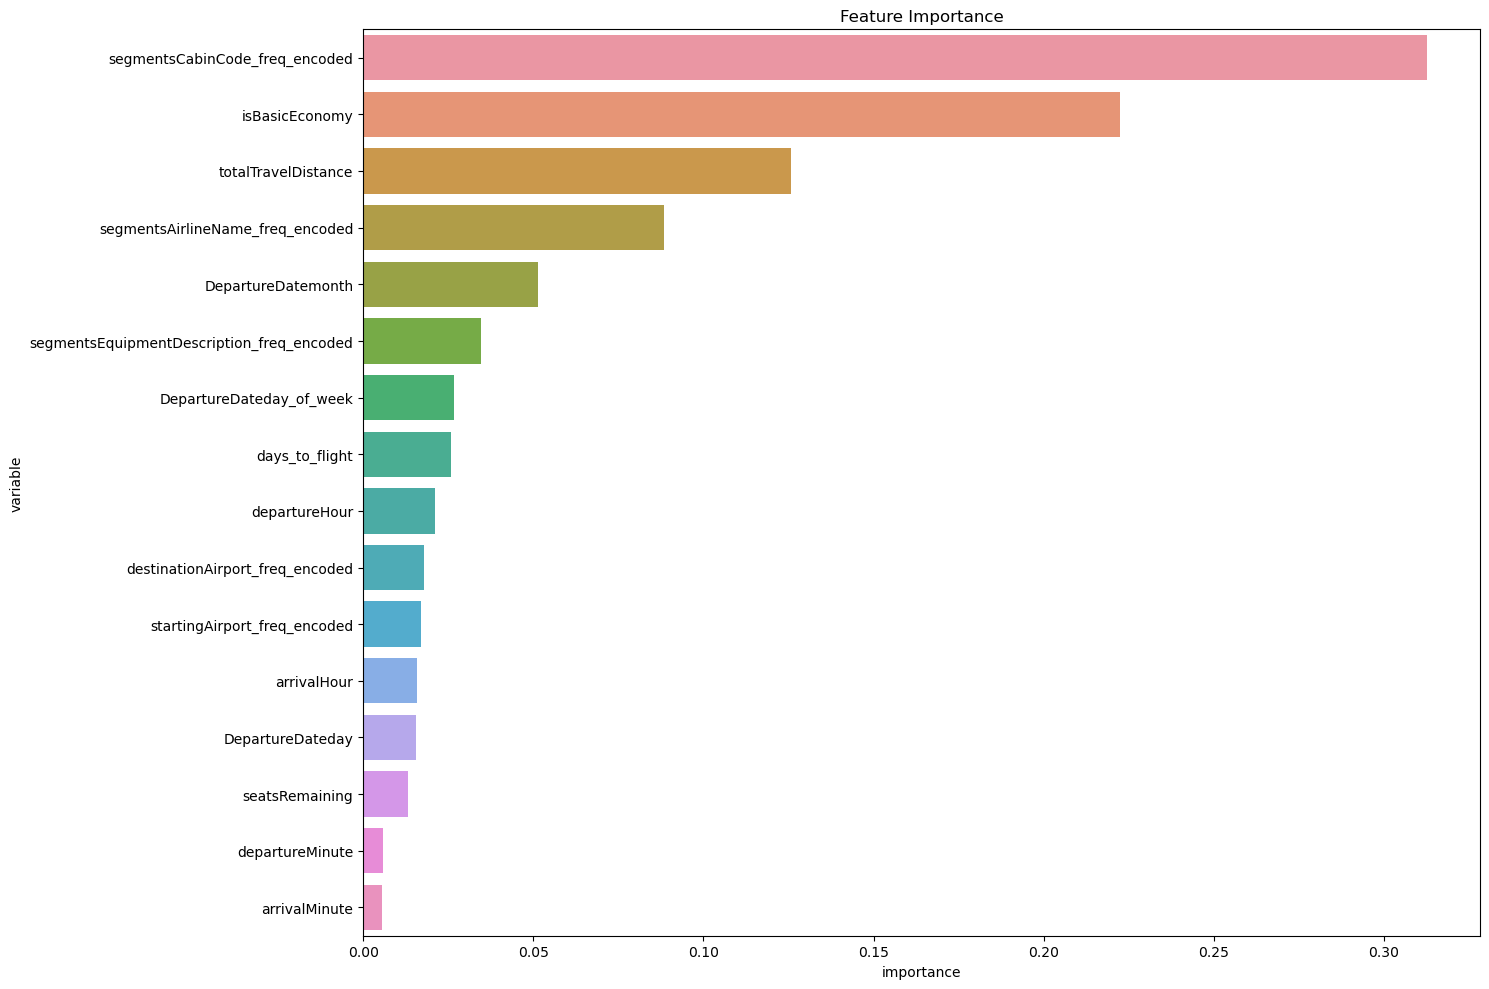

In [39]:
plt.figure(figsize=(15,10))
sns.barplot(x="importance",
            y="variable",
            data=importance)
plt.title('Feature Importance')
plt.tight_layout()

In [ ]:
#Plotting Train Test Scores bar chart

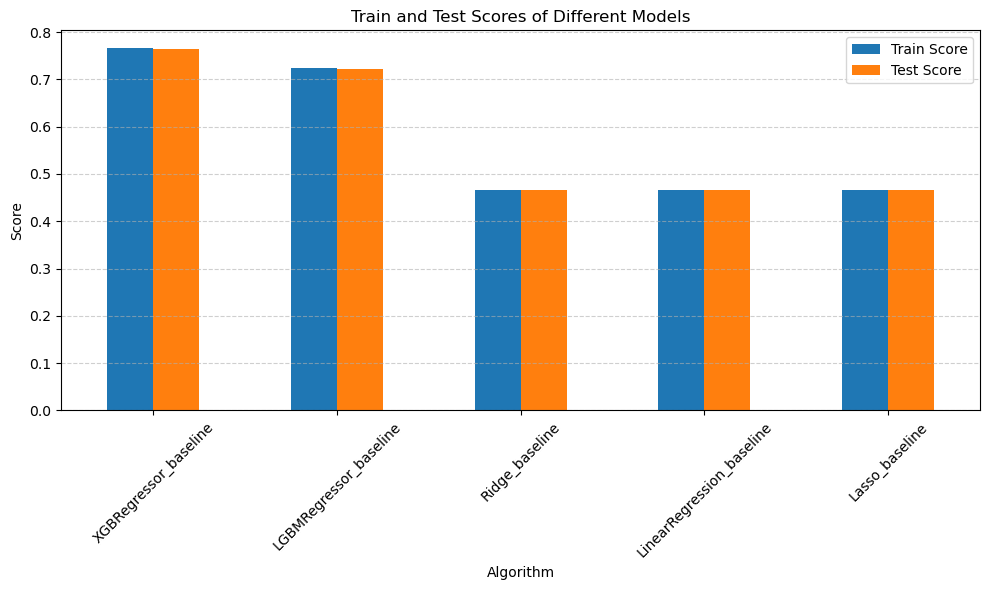

In [42]:
result_raw_model[["Train_Score", "Test_Score"]].plot(kind="bar", figsize=(10, 6))
plt.title("Train and Test Scores of Different Models")
plt.xlabel("Algorithm")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(["Train Score", "Test Score"])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 12728201, number of used features: 16
[LightGBM] [Info] Start training from score 223.368443


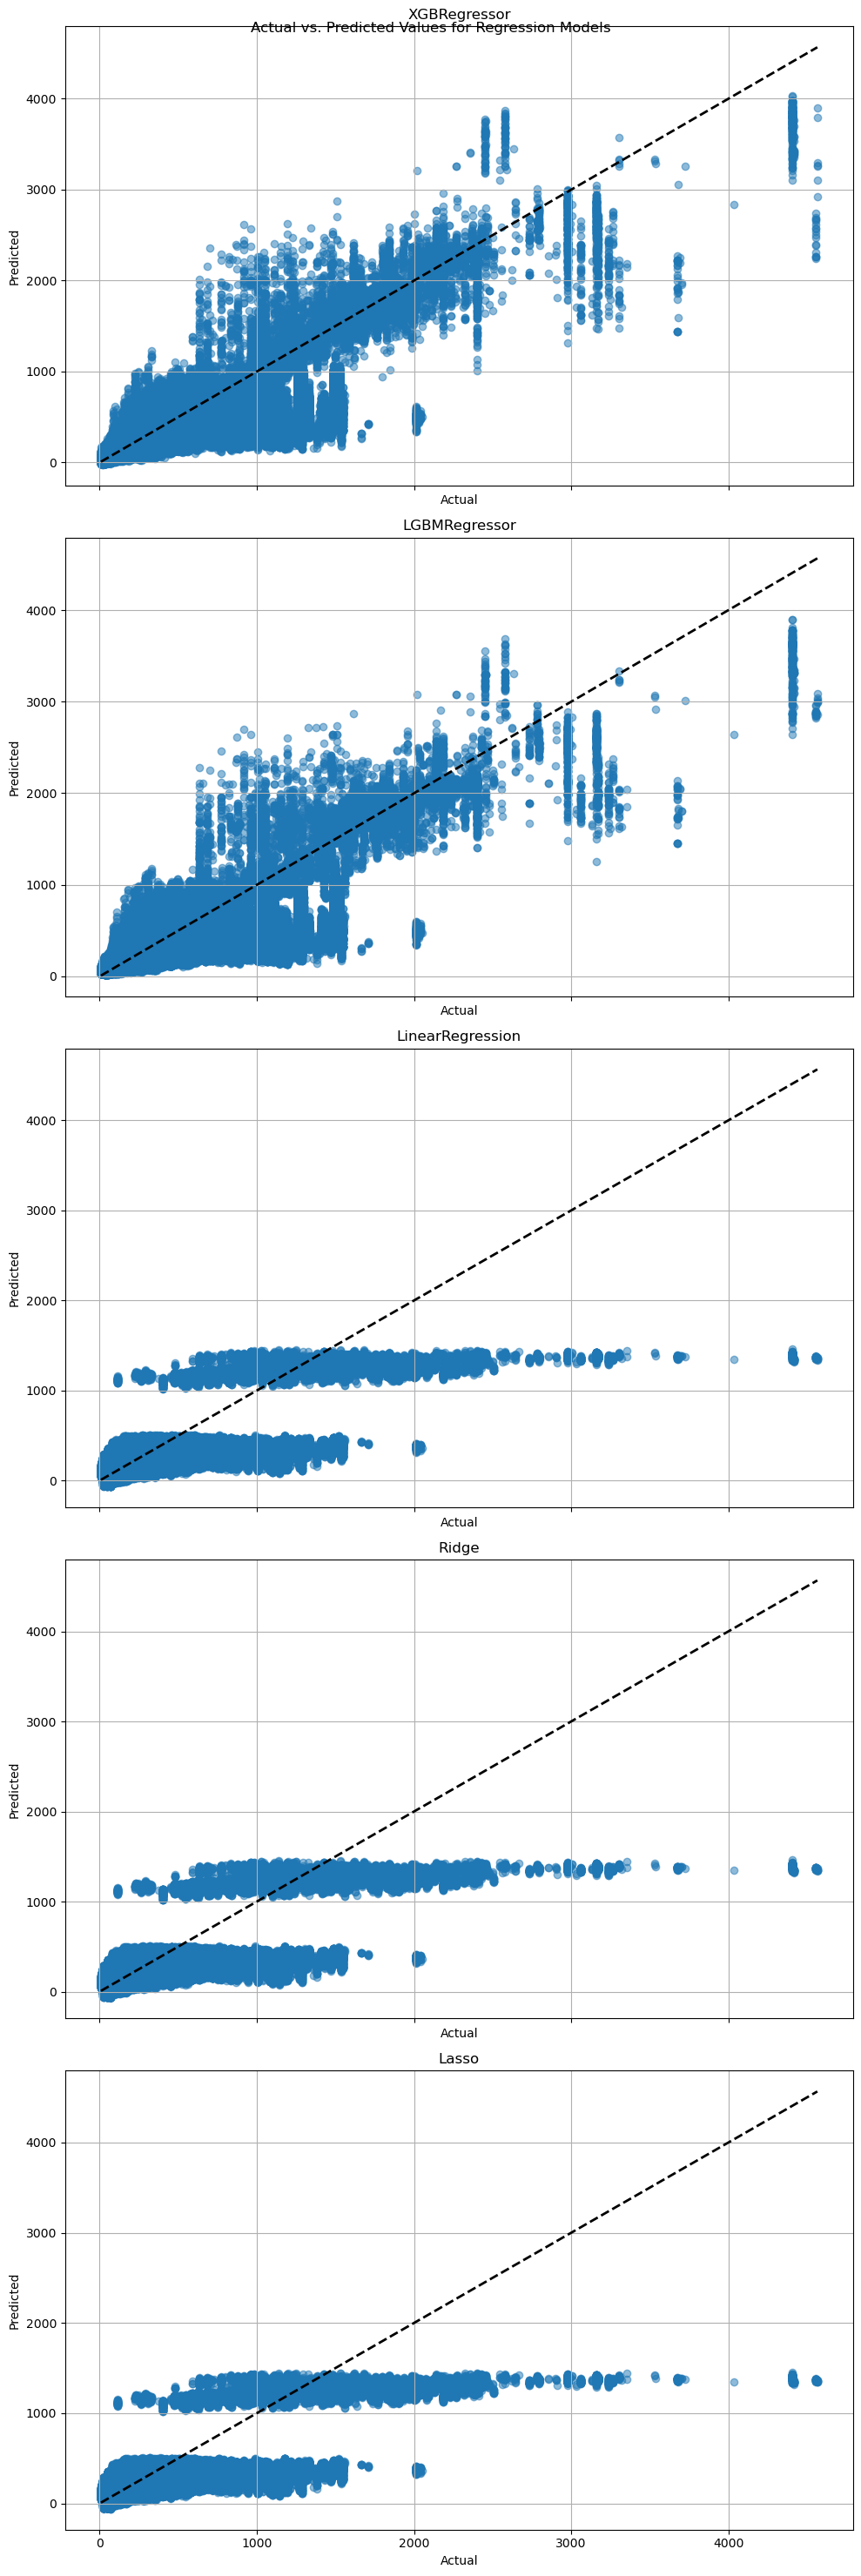

In [45]:
import matplotlib.pyplot as plt

# creating subplots
fig, axs = plt.subplots(len(algo), 1, figsize=(10, 6 * len(algo)), sharex=True)

# here we iterate through each algorithm we ran and plot actual vs. predicted values
for i, model in enumerate(algo):
    # Fit the model
    model.fit(X_train, y_train)
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Plot actual vs. predicted values
    axs[i].scatter(y_test, y_pred, alpha=0.5)
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axs[i].set_title(str(model).split("(")[0])
    axs[i].set_xlabel('Actual')
    axs[i].set_ylabel('Predicted')
    axs[i].grid(True)

# Set common labels and title
fig.suptitle('Actual vs. Predicted Values for Regression Models')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 12728201, number of used features: 16
[LightGBM] [Info] Start training from score 223.368443


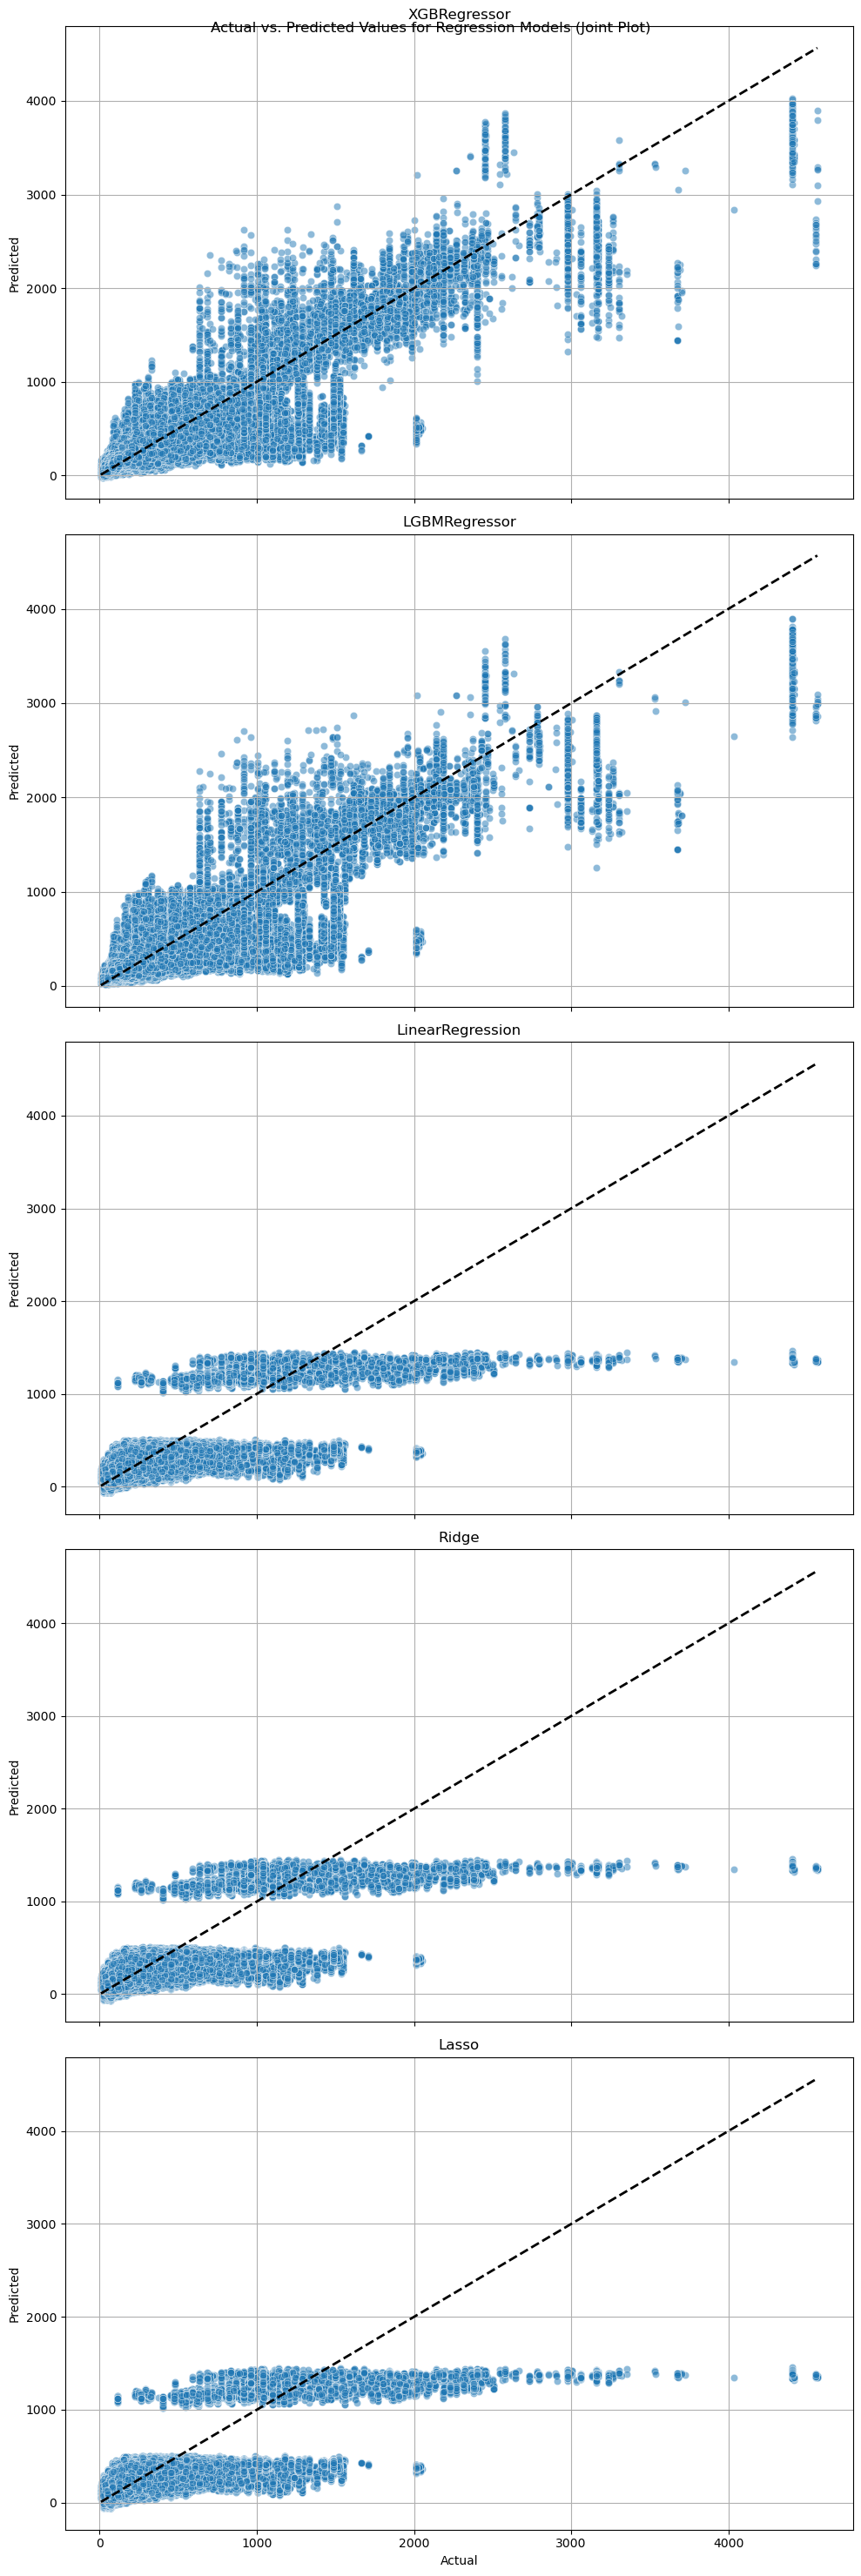

In [47]:
import seaborn as sns

# creating subplots again 
fig, axs = plt.subplots(len(algo), 1, figsize=(10, 6 * len(algo)), sharex=True)

# joint plots of actual vs. predicted values
for i, model in enumerate(algo):
    # Fit the model
    model.fit(X_train, y_train)
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Plot
    sns.scatterplot(x=y_test, y=y_pred, ax=axs[i], alpha=0.5)
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axs[i].set_title(str(model).split("(")[0])
    axs[i].set_xlabel('Actual')
    axs[i].set_ylabel('Predicted')
    axs[i].grid(True)

#  common labels and title
fig.suptitle('Actual vs. Predicted Values for Regression Models (Joint Plot)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()


In [40]:
# from sklearn.model_selection import GridSearchCV

# # Define parameter grids for each model
# param_grid_xgb = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001]
# }

# param_grid_lgbm = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001]
# }

# param_grid_ridge = {
#     'alpha': [0.1, 0.5, 1.0, 5.0]
# }

# param_grid_lasso = {
#     'alpha': [0.1, 0.5, 1.0, 5.0]
# }

# # Perform GridSearchCV for each model
# xgb_grid = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid_xgb, cv=5)
# xgb_grid.fit(X_train, y_train)

# lgbm_grid = GridSearchCV(lightgbm.LGBMRegressor(random_state=42), param_grid_lgbm, cv=5)
# lgbm_grid.fit(X_train, y_train)

# ridge_grid = GridSearchCV(Ridge(random_state=42), param_grid_ridge, cv=5)
# ridge_grid.fit(X_train, y_train)

# lasso_grid = GridSearchCV(Lasso(random_state=42), param_grid_lasso, cv=5)
# lasso_grid.fit(X_train, y_train)

# # Get the best parameters for each model
# best_params_xgb = xgb_grid.best_params_
# best_params_lgbm = lgbm_grid.best_params_
# best_params_ridge = ridge_grid.best_params_
# best_params_lasso = lasso_grid.best_params_

# print("Best parameters for XGBRegressor:", best_params_xgb)
# print("Best parameters for LGBMRegressor:", best_params_lgbm)
# print("Best parameters for Ridge Regression:", best_params_ridge)
# print("Best parameters for Lasso Regression:", best_params_lasso)

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x141c830d0>>
Traceback (most recent call last):
  File "/Users/elliot/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 641, in _next_wrapper
    return self._handle_exception(lambda: self.next(input_data), 0)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/elliot/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 557, in _handle_exception
    return fn()
           ^^^^
  File "/Users/elliot/anaconda3/lib/python3.11/site-packages/xgboost/core.py", line 641, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/elliot/anaconda3/lib/python3.11/site-packages/xgboost/data.py", line 1280, in next
    input_data(**self.kwargs)
  File "/Users/elliot/anaconda3/lib/python3.11/site-packages/xg

KeyboardInterrupt: 

In [ ]:
#Hyperparameter tuning setup 
# param_grid = {
#     "n_estimators":[100,200,300],
#     "max_depth":[10, 50, 100],
#     "max_features":[6,8,10,12,14,16]
# }

# rf = RandomForestRegressor(random_state = 42)

# rf_tuned = GridSearchCV(estimator = rf,
#                             param_grid = param_grid,
#                             cv = 2,
#                             n_jobs=-1,
#                         verbose=0)

# rf_tuned.fit(X_train, y_train)
# rf_tuned.best_estimator_

In [ ]:
# mtr = df_finalEy_dropped.corr()
# mask = np.zeros_like(mtr)
# mask[np.triu_indices_from(mask)] = True
# fig, ax = plt.subplots(figsize=(16,12))
# plt.suptitle("Correlation Matrix of Columns in Heatmap", size=24)
# sns.heatmap(mtr, mask= mask, annot=True, annot_kws={"size": 10});

In [ ]:
# mtr = df_finalEy_dropped.corr()
# mask = np.zeros_like(mtr)
# mask[np.triu_indices_from(mask)] = True
# fig, ax = plt.subplots(figsize=(16,12))
# plt.suptitle("Correlation Matrix of Columns in Heatmap", size=24)
# sns.heatmap(mtr, mask= mask, annot=True, annot_kws={"size": 10});


In [ ]:
# import numpy as np
# corr_matrix = df_finalEy_dropped.corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# [column for column in upper.columns if any(upper[column] > 0.75)]

In [ ]:
# df_finalEy_dropped.corr().abs().unstack().sort_values(ascending =False )["baseFare"]

In [20]:
# del df_finalEy_dropped["isRefundable"]

In [21]:
# del df_finalEy_dropped["fareRatio"]

In [ ]:
df_finalEy_dropped